# Students: Lin Yang, Mariia Isaieva, Martin Sejas <center>NLP Course <br><small>Graded Project Instructions <br>Spring 2023</small></center>

About the dataset: 

List of tweet texts with emotion labels like joy, sadness, fear, anger... 
Dataset is split into train, test and validation sets for building the machine learning model. At first, you are 
given only train and test sets. The validation one will be given in the end of the project for you to check 
the final performance of your algorithm (to make sure there is no overfitting over the test data). 
You can work on this project on group of one, two or three students. This exercise is mandatory, not 
giving it back is equivalent to getting to lowest grade. 
Goal: 

• Train different kind of models able to classify each text according to the sentiment mainly present 
in it 

• Compare the results of your different models and try to analyze and explain the differences

Train different classification models relying mainly on 

1. A Fully Connected Neural Network (see Course 2) 5 points 

2. A Recurrent Neural Network, based on LSTM or GRU (see Course 3) 5 points 

3. A fine-tuned Transformer Architecture from a pretrained model that can be found on sites 
like HuggingFace (see Course 4) 5 points 

4. Compare the different models to find the best approach and try to duplicate it on a “real life” 
text classification approach (this new “real life” dataset will be given to you soon) 5 points

# Loading and Preprocessing the data sets

In [29]:
import pandas as pd
import numpy as np

The dataset is a tweets sentiment dataset, it's quite straightforward, there are only 2 columns, the tweet itself, and the sentiment attached to it. We have been provided a train set and a test set.

In [30]:
df_train = pd.read_csv('./train.txt', header=None, delimiter=';')
df_test = pd.read_csv('./test.txt', header=None, delimiter=';')
df_train = df_train.rename(columns={0: 'tweet', 1: 'sentiment'})
df_test = df_test.rename(columns={0: 'tweet', 1: 'sentiment'})
df_train.head()

,tweet,sentiment
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


After loading our dataset we can see the class (sentiment) distribution of our tweets.

In [31]:
df_train['sentiment'].value_counts(), df_train.shape

(sentiment
 joy         5362
 sadness     4666
 anger       2159
 fear        1937
 love        1304
 surprise     572
 Name: count, dtype: int64,
 (16000, 2))

In [32]:
df_test['sentiment'].value_counts(), df_test.shape

(sentiment
 joy         695
 sadness     581
 anger       275
 fear        224
 love        159
 surprise     66
 Name: count, dtype: int64,
 (2000, 2))

We can see here that there are class inbalances. Especially regarding joy and surprise.

We will also separate each tweet from it's label to train.

In [33]:
texts_train = df_train['tweet']
texts_test = df_test['tweet']

In [34]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train = le.fit_transform(df_train['sentiment'])
y_test = le.transform(df_test['sentiment'])
y_train

array([4, 4, 0, ..., 2, 0, 4])

## Pre-Processing the tweets (Lemmetizing) with the Spacy library.

### Lemmetization

We are going to be using the famous [Spacy](https://spacy.io/) Library for tokenization, it's the best performing one in terms of computational cost and performance.

We will be loading the english core *medium* dataset.



To have spacy working please make sure to run the following commands. 

```bash
pip install spacy
```

Once the package has been installed, make sure to download the language model, in our case, *en-core-web-md* will be used, and can be downloaded by the following command. 

```bash 
python -m spacy download en_core_web_md
```

In [35]:
import spacy
nlp = spacy.load('en_core_web_md')

#Function to tokenize
def preprocess_text(text):
    #every tweet will become a document 
    doc = nlp(text)
    
    #Creating a list of tokens by lemmatizing the words, filtering stop words.
    tokens = [token.lemma_.lower().strip() for token in doc if not token.is_stop]
    
    #Join all the words in one sentence
    return ' '.join(tokens)

With the *preprocess_text* function, we will pre-process the tweet text, and with that we can apply it to both of our dataframes as a new series, and see the output.

*Warning this cell takes over 2 minutes to run!*

In [36]:
df_train['processed'] = df_train['tweet'].apply(preprocess_text)
df_test['processed'] = df_test['tweet'].apply(preprocess_text)
df_train.head()

,tweet,sentiment,processed
0,i didnt feel humiliated,sadness,not feel humiliate
1,i can go from feeling so hopeless to so damned...,sadness,feel hopeless damn hopeful care awake
2,im grabbing a minute to post i feel greedy wrong,anger,m grab minute post feel greedy wrong
3,i am ever feeling nostalgic about the fireplac...,love,feel nostalgic fireplace know property
4,i am feeling grouchy,anger,feel grouchy


## Task 1- Fully Connected Neural Network(5 Points)
### TF-IDF and Latent DirichletAllocation embedding for Sequential Neural Network


We will be using sklearn's TFidfVectorizer to be able to process the data and feed it into our Neural Network.

In [38]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

tfidf = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')

dtm_train = tfidf.fit_transform(df_train['processed'])
dtm_test = tfidf.transform(df_test['processed'])
dtm_train.shape

(16000, 5587)

Split the training set to training and validation sets for training the model

In [39]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split

X_train_ = dtm_train.toarray()
X_test_ = dtm_test.toarray()
y_train_ = y_train
y_test_ = y_test
# X_train_ = np.vstack((X_train_, X_test_))
# y_train_ = np.concatenate((y_train, y_test))

print(X_train_.shape)

class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)


# X_train_, X_test_, y_train, y_test_ = train_test_split(X_train_, y_train, test_size=0.2, random_state=42, stratify=y_train)
X_train_, X_val_, y_train_, y_val_ = train_test_split(X_train_, y_train, test_size=0.2, random_state=42, stratify=y_train)

print(X_train_.shape)
print(X_val_.shape)
print(X_test_.shape)
print(y_train_.shape)
print(y_val_.shape)
print(y_test_.shape)

(16000, 5587)
(12800, 5587)
(3200, 5587)
(2000, 5587)
(12800,)
(3200,)
(2000,)


Encode the label in one hot encoding fashion

In [41]:
from keras.utils import to_categorical

y_train_encoded = to_categorical(y_train_)
y_test_encoded = to_categorical(y_test_)
y_val_encoded = to_categorical(y_val_)
y_train_encoded.shape, y_test_encoded.shape, y_val_encoded.shape

((12800, 6), (2000, 6), (3200, 6))

In [98]:
y_train_encoded, y_train_encoded.shape

(array([[0., 0., 0., 0., 1., 0.],
        [0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0.],
        ...,
        [0., 0., 0., 0., 1., 0.],
        [0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0.]], dtype=float32),
 (12800, 6))

##### Experiements No need to check

In [6]:
# def get_tweets_sentiment(df_train):
#     i = 0
#     dict_label = []
#     list_embed = []    
#     size_data = df_train.shape[0]

#     for sentence in list(df_train.itertuples())[0:size_data]:
#         text_embed =np.ndarray.flatten(nlp(sentence.tweet).vector)
#         observed_sentiment = sentence.sentiment
#         if observed_sentiment == 'joy':
#             label = 0.0
#         elif observed_sentiment == 'sadness':
#             label = 1.0
#         elif observed_sentiment == 'anger':
#             label = 2.0
#         elif observed_sentiment == 'fear':
#             label = 3.0
#         elif observed_sentiment == 'love':
#             label = 4.0
#         else:
#             label = 5.0
#         dict_label.append(label)
#         list_embed.append(np.array([text_embed]))
#         i += 1
#     return dict_label, list_embed

In [7]:
# training_set = get_tweets_sentiment(df_train)
# test_set = get_tweets_sentiment(df_test)

In [378]:
# y_train_label = training_set[0]
# X_train_embed = np.array(training_set[1])

# y_test_label = test_set[0]
# X_test_embed = np.array(test_set[1])

In [379]:
# X_train = pd.DataFrame.from_dict(X_train_embed_dict, orient='index')
# X_test = pd.DataFrame.from_dict(X_test_embed_dict, orient='index')

In [380]:
# y_train = pd.DataFrame({'sentiment': pd.Series(y_train_label)})
# y_test = pd.DataFrame({'sentiment': pd.Series(y_test_label)})

In [381]:
# X_train = X_train.join(y_train)
# X_test = X_test.join(y_test)

In [382]:
# y_train = X_train['sentiment']
# X_train = X_train.drop('sentiment', axis=1)

# y_test = X_test['sentiment']
# X_test = X_test.drop('sentiment', axis=1)

In [383]:
# from keras.utils import to_categorical

# y_train_encoded = to_categorical(y_train)
# y_test_encoded = to_categorical(y_test)
# print(y_train_encoded.shape)

(16000, 6)


In [401]:
# min_num = np.inf
# max_num = -np.inf

# for i in range(300):
#     if min(X_train.iloc[:, i]) < min_num:
#         min_num = min(X_train.iloc[:, i])
#     if max(X_train.iloc[:, i]) > max_num:
#         max_num = max(X_train.iloc[:, i])
# min_num, max_num

(-11.600116729736328, 13.568775177001953)

In [402]:
# from sklearn.preprocessing import StandardScaler
# std = StandardScaler()

# X_train = std.fit_transform(X_train)
# X_test = std.transform(X_test)

# Fully connect NN

Build the fully connected NN with tensorflow.

The first layer has a high number of nerons because the input data set has `>5000` features.

In [82]:
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import Sequential
import tensorflow as tf

model = Sequential()
model.add(Dense(4096, activation='selu', kernel_initializer='lecun_normal', input_shape=(X_train_.shape[1],), kernel_regularizer=tf.keras.regularizers.l2(0.01)))
model.add(Dense(2048, activation='selu', kernel_initializer='lecun_normal', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
# model.add(Dropout(0.5))
model.add(Dense(1024, activation='selu', kernel_initializer='lecun_normal', kernel_regularizer=tf.keras.regularizers.l2(0.1)))
model.add(Dropout(0.2))
# model.add(Dense(512, activation='selu', kernel_initializer='lecun_normal', ))
# model.add(Dropout(0.5))
# model.add(Dense(128, activation='selu', kernel_initializer='lecun_normal', ))
model.add(Dense(64, activation='selu',))
model.add(Dense(6, activation='softmax'))

model.layers[-1].bias.assign(class_weights)
model.compile(optimizer='Adam', loss=tf.losses.categorical_crossentropy, metrics=['accuracy'])
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_46 (Dense)            (None, 4096)              22888448  
                                                                 
 dense_47 (Dense)            (None, 2048)              8390656   
                                                                 
 dense_48 (Dense)            (None, 1024)              2098176   
                                                                 
 dropout_16 (Dropout)        (None, 1024)              0         
                                                                 
 dense_49 (Dense)            (None, 64)                65600     
                                                                 
 dense_50 (Dense)            (None, 6)                 390       
                                                                 
Total params: 33443270 (127.58 MB)
Trainable params: 3

Set up the early stopping condition and use a dynamic learning rate scheduler

In [83]:
import math
from keras.callbacks import LearningRateScheduler
from keras.callbacks import EarlyStopping, CallbackList, ReduceLROnPlateau


def step_decay(epoch):
    initial_lrate = 0.001
    drop = 0.5
    epochs_drop = 10.0
    lrate = initial_lrate * math.pow(drop, math.floor((1 + epoch) / epochs_drop))
    return lrate

lr_scheduler = LearningRateScheduler(step_decay)

early_stopping = EarlyStopping(monitor='val_loss', restore_best_weights=True, patience=5) # 

Training the model

In [84]:
history = model.fit(X_train_, y_train_encoded, validation_data=(X_val_, y_val_encoded), epochs=100, batch_size=1024, callbacks=[early_stopping, lr_scheduler])

Epoch 1/100
13/13 [==============================] - 5s 316ms/step - loss: 104.2934 - accuracy: 0.4451 - val_loss: 48.7232 - val_accuracy: 0.7081 - lr: 0.0010
Epoch 2/100
13/13 [==============================] - 4s 277ms/step - loss: 28.9494 - accuracy: 0.7758 - val_loss: 13.0855 - val_accuracy: 0.8059 - lr: 0.0010
Epoch 3/100
13/13 [==============================] - 4s 289ms/step - loss: 8.0179 - accuracy: 0.8298 - val_loss: 4.0728 - val_accuracy: 0.8191 - lr: 0.0010
Epoch 4/100
13/13 [==============================] - 4s 330ms/step - loss: 2.7305 - accuracy: 0.8621 - val_loss: 1.7581 - val_accuracy: 0.8281 - lr: 0.0010
Epoch 5/100
13/13 [==============================] - 4s 294ms/step - loss: 1.3600 - accuracy: 0.8773 - val_loss: 1.1855 - val_accuracy: 0.8344 - lr: 0.0010
Epoch 6/100
13/13 [==============================] - 4s 288ms/step - loss: 1.0211 - accuracy: 0.8838 - val_loss: 1.0545 - val_accuracy: 0.8363 - lr: 0.0010
Epoch 7/100
13/13 [==============================] - 4s 297

Plot the training loss

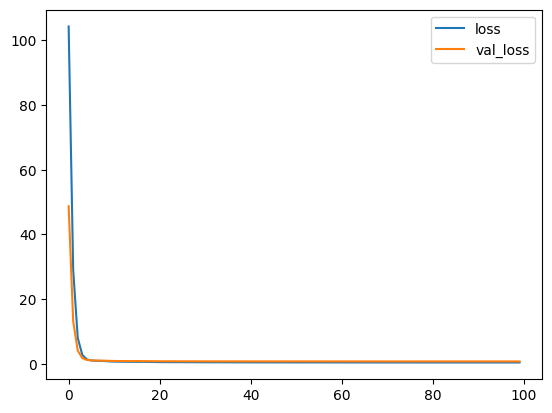

In [86]:
import matplotlib.pyplot as plt

loss, val_loss = history.history['loss'], history.history['val_loss']

plt.plot(loss, label='loss')
plt.plot(val_loss, label='val_loss')
plt.legend()
plt.show()

Test the model on test dataset

In [87]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

predictions = model.predict(X_test_)
prediction_labels = predictions.argmax(axis=1)
print(classification_report(y_test, prediction_labels))
print(confusion_matrix(y_test_, prediction_labels))
print(accuracy_score(y_test_, prediction_labels))

63/63 [==============================] - 1s 14ms/step
              precision    recall  f1-score   support

           0       0.87      0.82      0.84       275
           1       0.80      0.80      0.80       224
           2       0.87      0.92      0.89       695
           3       0.70      0.67      0.69       159
           4       0.88      0.89      0.89       581
           5       0.75      0.55      0.63        66

    accuracy                           0.85      2000
   macro avg       0.81      0.77      0.79      2000
weighted avg       0.85      0.85      0.85      2000

[[226   8  12   3  26   0]
 [  9 179   8   0  20   8]
 [  6   7 636  35   9   2]
 [  2   1  40 107   9   0]
 [ 18  15  21   7 518   2]
 [  0  13  12   0   5  36]]
0.851


I have tried several dozens of times on this model: increasing and reducing the layers, increasing and reducing the neurons in each layer, tuning the regularization parameter, changing regularization, tuning the learning rate, batch size, *etc*.

I also tried to experiment on the different input, using different representation of original text for model training, such as embedding with spacy. There were several different accuracy ceiling for my model from low to high with increasing the model complexity, `34%` to `56%`, and `86%`. And finally I got this result with the tf_idf matrix representation for training the model while the scale of the model is large with nearly 34 million. And the Accuracy on test was improved from `< 40%` to now `> 80%`.

With `> 80%` accuracy, I also run dozens of experimentation to improve the accuracy, however, it is very hard to get a better accuracy, in the meantime I am already overfitting with the training set. I tried to tackle the overfitting problem, but I will get lower accuracy. So I decided to keep this model setup.

Save the model, the folder of saved model is ignored for commit to github

In [304]:
model.save('FNN_model')

INFO:tensorflow:Assets written to: FNN_model/assets


INFO:tensorflow:Assets written to: FNN_model/assets


## Now let's test on the real case data

load the real case data

In [100]:
df_r_train = pd.read_csv('./real_case_data/train.csv')
df_r_test = pd.read_csv('./real_case_data/test.csv')

df_r_train.head(), df_r_test.head()

(   Unnamed: 0                                      article_title  is_ecology
 0        1079  Stations essence à Rochefort-en-Terre : les me...           0
 1        1515  À Brest, le chantier de La Boussole se fait at...           0
 2          51  Météorite en Normandie : à la recherche de pré...           0
 3        1419  Résultats trimestriels mitigés pour les géants...           0
 4        2181  Opinion | Sobriété énergétique : les solutions...           1,
    Unnamed: 0                                      article_title  is_ecology
 0          56  Plan de sortie de flotte: seules sept demandes...           0
 1         279  Agressé, l’agriculteur Paul François, figure d...           1
 2           1  Stations essence à La Bouillie : les meilleurs...           0
 3         213  Accord sur le partage de la valeur: le Medef n...           0
 4         282  ZFE et et transports en commun : bus et cars d...           1)

Tokenize the data

In [101]:
df_r_train['processed'] = df_r_train['article_title'].apply(preprocess_text)
df_r_test['processed'] = df_r_test['article_title'].apply(preprocess_text)
df_r_train.head(), df_r_test.head()

(   Unnamed: 0                                      article_title  is_ecology  \
 0        1079  Stations essence à Rochefort-en-Terre : les me...           0   
 1        1515  À Brest, le chantier de La Boussole se fait at...           0   
 2          51  Météorite en Normandie : à la recherche de pré...           0   
 3        1419  Résultats trimestriels mitigés pour les géants...           0   
 4        2181  Opinion | Sobriété énergétique : les solutions...           1   
 
                                            processed  
 0  station essence à rochefort - en - terre : les...  
 1  à brest , le chantier de la boussole se fait a...  
 2  météorite en normandie : à la recherche de pré...  
 3  résultats trimestriels mitigés pour les géants...  
 4  opinion | sobriété énergétique : les solution ...  ,
    Unnamed: 0                                      article_title  is_ecology  \
 0          56  Plan de sortie de flotte: seules sept demandes...           0   
 1         27

TFIDF transformation

In [102]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from nltk.corpus import stopwords

final_stopwords_list = stopwords.words('english') + stopwords.words('french')

tfidf = TfidfVectorizer(max_df=0.95, min_df=2, stop_words=final_stopwords_list)

dtm_r_train = tfidf.fit_transform(df_r_train['processed'])
dtm_r_test = tfidf.transform(df_r_test['processed'])
dtm_r_train.shape, dtm_r_test.shape

((2215, 2446), (294, 2446))

Set the X_r_train

In [118]:
X_r_train = dtm_r_train.toarray()
y_r_train = df_r_train['is_ecology']

X_r_test = dtm_r_test.toarray()
y_r_test = df_r_test['is_ecology']

y_r_train_encoded = to_categorical(y_r_train)
y_r_test_encoded = to_categorical(y_r_test)

Split the train and validation data set

In [119]:
from sklearn.model_selection import train_test_split

# class_weights = compute_class_weight('balanced', classes=np.unique(y_r_train), y=y_r_train)
X_r_train, X_r_val, y_r_train_encoded, y_r_val_encoded = train_test_split(X_r_train, y_r_train_encoded, test_size=0.2, random_state=42)

In [122]:
X_r_train.shape, X_r_val.shape, y_r_train_encoded.shape, y_r_val_encoded.shape

((1772, 2446), (443, 2446), (1772, 2), (443, 2))

Build the model with same architecture, but change the last output layer as we have two categories in this case

In [140]:
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import Sequential
import tensorflow as tf

model = Sequential()
model.add(Dense(2048, activation='selu', kernel_initializer='lecun_normal', input_shape=(X_r_train.shape[1],), kernel_regularizer=tf.keras.regularizers.l2(0.01)))
model.add(Dense(1024, activation='selu', kernel_initializer='lecun_normal', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
# model.add(Dropout(0.5))
model.add(Dense(512, activation='selu', kernel_initializer='lecun_normal', kernel_regularizer=tf.keras.regularizers.l2(0.1)))
model.add(Dropout(0.2))
model.add(Dense(256, activation='selu', kernel_initializer='lecun_normal', ))
# model.add(Dropout(0.5))
# model.add(Dense(128, activation='selu', kernel_initializer='lecun_normal', ))
model.add(Dense(64, activation='selu', kernel_initializer='lecun_normal',))
model.add(Dense(2, activation='softmax'))

model.compile(optimizer='Adam', loss=tf.losses.categorical_crossentropy, metrics=['accuracy'])
model.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_91 (Dense)            (None, 2048)              5011456   
                                                                 
 dense_92 (Dense)            (None, 1024)              2098176   
                                                                 
 dense_93 (Dense)            (None, 512)               524800    
                                                                 
 dropout_25 (Dropout)        (None, 512)               0         
                                                                 
 dense_94 (Dense)            (None, 256)               131328    
                                                                 
 dense_95 (Dense)            (None, 64)                16448     
                                                                 
 dense_96 (Dense)            (None, 2)               

Set up early stopping and dynamic learning rate

In [141]:
import math
from keras.callbacks import LearningRateScheduler
from keras.callbacks import EarlyStopping, CallbackList, ReduceLROnPlateau


def step_decay(epoch):
    initial_lrate = 0.001
    drop = 0.5
    epochs_drop = 10.0
    lrate = initial_lrate * math.pow(drop, math.floor((1 + epoch) / epochs_drop))
    return lrate

lr_scheduler = LearningRateScheduler(step_decay)

early_stopping = EarlyStopping(monitor='val_loss', restore_best_weights=True, patience=5) # 

Train the model

In [142]:
history = model.fit(X_r_train, y_r_train_encoded, validation_data=(X_r_val, y_r_val_encoded), epochs=100, batch_size=1024, callbacks=[early_stopping, lr_scheduler])

Epoch 1/100
2/2 [==============================] - 1s 577ms/step - loss: 80.4360 - accuracy: 0.6569 - val_loss: 72.9263 - val_accuracy: 0.9887 - lr: 0.0010
Epoch 2/100
2/2 [==============================] - 0s 147ms/step - loss: 71.1564 - accuracy: 0.9735 - val_loss: 64.3972 - val_accuracy: 0.9887 - lr: 0.0010
Epoch 3/100
2/2 [==============================] - 0s 155ms/step - loss: 62.7544 - accuracy: 0.9735 - val_loss: 56.6188 - val_accuracy: 0.9887 - lr: 0.0010
Epoch 4/100
2/2 [==============================] - 0s 153ms/step - loss: 55.1133 - accuracy: 0.9746 - val_loss: 49.6199 - val_accuracy: 0.9887 - lr: 0.0010
Epoch 5/100
2/2 [==============================] - 0s 163ms/step - loss: 48.2469 - accuracy: 0.9825 - val_loss: 43.3426 - val_accuracy: 0.9887 - lr: 0.0010
Epoch 6/100
2/2 [==============================] - 0s 165ms/step - loss: 42.1144 - accuracy: 0.9876 - val_loss: 37.7838 - val_accuracy: 0.9887 - lr: 0.0010
Epoch 7/100
2/2 [==============================] - 0s 157ms/step

In [143]:
predictions_r = model.predict(X_r_test)
prediction_labels_r = predictions_r.argmax(axis=1)
print(classification_report(y_r_test, prediction_labels_r))
print(confusion_matrix(y_r_test, prediction_labels_r))
print(accuracy_score(y_r_test, prediction_labels_r))

10/10 [==============================] - 0s 14ms/step
              precision    recall  f1-score   support

           0       0.83      1.00      0.91       241
           1       1.00      0.08      0.14        53

    accuracy                           0.83       294
   macro avg       0.92      0.54      0.52       294
weighted avg       0.86      0.83      0.77       294

[[241   0]
 [ 49   4]]
0.8333333333333334


# RNN, LSTM and GRU

In [11]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
import math
import tensorflow as tf

# 数据处理
tweets_train = df_train['tweet']
tweet_test = df_test['tweet']
labels_train = df_train['sentiment']
labels_test = df_test['sentiment']

verctorizer = TfidfVectorizer()
X_train_tfidf = verctorizer.fit_transform(tweets_train)
X_test_tfidf = verctorizer.transform(tweet_test)

max_sequence_length = 1000
X_train_padded = pad_sequences(X_train_tfidf.toarray(), maxlen=max_sequence_length)
X_test_padded = pad_sequences(X_test_tfidf.toarray(), maxlen=max_sequence_length)

le = LabelEncoder()
y_train_padded = le.fit_transform(labels_train)
y_test_padded = le.transform(labels_test)

# Convert labels to categorical if needed
# y_train_padded = to_categorical(y_train_padded)
# y_test_padded = to_categorical(y_test_padded)

num_classes = len(le.classes_)
vocab_size = len(verctorizer.vocabulary_)
embedding_dim = 100

# 设置学习率与early_stopping
def step_decay(epoch):
    initial_lrate = 0.01
    drop = 0.5
    epochs_drop = 10.0
    lrate = initial_lrate * math.pow(drop, math.floor((1 + epoch) / epochs_drop))
    return lrate

lr_scheduler = LearningRateScheduler(step_decay)
early_stopping = EarlyStopping(monitor='val_loss', restore_best_weights=True, patience=5)

# strategy = tf.distribute.OneDeviceStrategy(device='/gpu:0')
# 搭建模型
# with strategy.scope():
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=max_sequence_length))
model.add(LSTM(1024, recurrent_dropout=0.2))
model.add(Dense(512, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 1000, 100)         1518600   
                                                                 
 lstm_2 (LSTM)               (None, 1024)              4608000   
                                                                 
 dense_10 (Dense)            (None, 512)               524800    
                                                                 
 dense_11 (Dense)            (None, 256)               131328    
                                                                 
 dense_12 (Dense)            (None, 128)               32896     
                                                                 
 dense_13 (Dense)            (None, 64)                8256      
                                                                 
 dense_14 (Dense)            (None, 6)                

In [ ]:
# 训练模型
history = model.fit(X_train_padded, y_train_padded, batch_size=512, epochs=100,
                    validation_data=(X_test_padded, y_test_padded),
                    callbacks=[early_stopping, lr_scheduler])

In [ ]:
loss, val_loos = history['loss'], history['val_loss']

plt.plot(loss, label='Training loss')
plt.plot(val_loos, label='Validation loss')
plt.legend()
plt.show()

# Transformer based Pretrained model

In [3]:
df_train = pd.read_csv('./train.txt', header=None, delimiter=';')
df_test = pd.read_csv('./test.txt', header=None, delimiter=';')
df_train = df_train.rename(columns={0: 'tweet', 1: 'sentiment'})
df_test = df_test.rename(columns={0: 'tweet', 1: 'sentiment'})
df_train.head()

,tweet,sentiment
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


- Pytorch

In [15]:
from transformers import AutoTokenizer, AutoModel, BertTokenizer
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
import torch
import torch.nn as nn

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
encoded_input_train = tokenizer.batch_encode_plus(texts_train, padding=True, truncation=True, return_tensors='pt')
input_ids_train = encoded_input_train['input_ids']
attention_masks_train = encoded_input_train['attention_mask']

labels_train = df_train['sentiment']
le = LabelEncoder()
labels_train =le.fit_transform(labels_train)
labels_train = to_categorical(labels_train)
labels_train = torch.tensor(labels_train)


transformer_model = AutoModel.from_pretrained('bert-base-uncased')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
transformer_model.to(device)
optimizer = torch.optim.Adam(transformer_model.parameters(), lr=1e-5)
loss_fn = torch.nn.CrossEntropyLoss()

transformer_model.train()
input_ids_train = input_ids_train.to(device)
attention_masks_train = attention_masks_train.to(device)
labels_train = labels_train.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [9]:
from transformers import AutoTokenizer, AutoModel
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
transformer_model = AutoModel.from_pretrained('bert-base-uncased')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
transformer_model.to(device)
optimizer = torch.optim.Adam(transformer_model.parameters(), lr=1e-5)
loss_fn = torch.nn.CrossEntropyLoss()

texts_train = df_train['tweet']
labels_train = df_train['sentiment']
le = LabelEncoder()
labels_train = le.fit_transform(labels_train)
labels_train = to_categorical(labels_train)
labels_train = torch.tensor(labels_train).to(device)

# Tokenize texts_train
encoded_inputs = tokenizer(texts_train.tolist(), padding=True, truncation=True, return_tensors='pt')
input_ids_train = encoded_inputs['input_ids'].to(device)
attention_masks_train = encoded_inputs['attention_mask'].to(device)

train_dataset = TensorDataset(input_ids_train, attention_masks_train, labels_train)
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)

transformer_model.train()

linear_layer = nn.Linear(transformer_model.config.hidden_size, le.classes_.shape[0]).to(device)
nn.init.xavier_uniform_(linear_layer.weight)


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Parameter containing:
tensor([[ 0.0020, -0.0545, -0.0427,  ..., -0.0806, -0.0876,  0.0259],
        [-0.0798, -0.0748,  0.0032,  ...,  0.0238,  0.0873, -0.0114],
        [-0.0061, -0.0134,  0.0178,  ...,  0.0522,  0.0160, -0.0167],
        [ 0.0459, -0.0031,  0.0880,  ...,  0.0709, -0.0803,  0.0415],
        [ 0.0195, -0.0304, -0.0010,  ...,  0.0190, -0.0422,  0.0654],
        [ 0.0330,  0.0297, -0.0718,  ...,  0.0068,  0.0588, -0.0725]],
       device='cuda:0', requires_grad=True)

In [10]:
accumulation_steps = 4  # Accumulate gradients over 4 batches
total_losses = []
for epoch in range(30):
    total_loss = 0
    for batch_idx, (batch_input_ids, batch_attention_masks, batch_labels) in enumerate(train_dataloader):
        optimizer.zero_grad()

        batch_input_ids = batch_input_ids.to(device)
        batch_attention_masks = batch_attention_masks.to(device)
        batch_labels = batch_labels.to(device)

        outputs = transformer_model(input_ids=batch_input_ids, attention_mask=batch_attention_masks)
        pooled_output = outputs.pooler_output
        logits = linear_layer(pooled_output)

        loss = loss_fn(logits, torch.argmax(batch_labels, dim=1))
        loss = loss / accumulation_steps  # Scale the loss

        loss.backward()

        if (batch_idx + 1) % accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()

        total_loss += loss.item()
    total_losses.append(total_loss / len(train_dataloader))
    print(f"Epoch {epoch + 1} - Average Loss: {total_loss / len(train_dataloader)}")

Epoch 1 - Average Loss: 0.3431227789670229
Epoch 2 - Average Loss: 0.15944166499562562
Epoch 3 - Average Loss: 0.07959097695350648
Epoch 4 - Average Loss: 0.05580993509478867
Epoch 5 - Average Loss: 0.04338084980705753
Epoch 6 - Average Loss: 0.03838919259759132
Epoch 7 - Average Loss: 0.03426969006942818
Epoch 8 - Average Loss: 0.030790360981074627
Epoch 9 - Average Loss: 0.027876388156437316
Epoch 10 - Average Loss: 0.02630211615844746
Epoch 11 - Average Loss: 0.02624506679715705
Epoch 12 - Average Loss: 0.025121578735153888
Epoch 13 - Average Loss: 0.023111631666950416
Epoch 14 - Average Loss: 0.0223442898268695
Epoch 15 - Average Loss: 0.02088869621325284
Epoch 16 - Average Loss: 0.02109514506465348
Epoch 17 - Average Loss: 0.018455659539700717
Epoch 18 - Average Loss: 0.017144603587701566
Epoch 19 - Average Loss: 0.017530029333669518
Epoch 20 - Average Loss: 0.017526032913141535
Epoch 21 - Average Loss: 0.016154191977955635
Epoch 22 - Average Loss: 0.015543671893923602
Epoch 23 - 

In [18]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

# Tokenize the input test text and convert it to input tensors
texts_test = df_test['tweet']
labels_test = df_test['sentiment']
le = LabelEncoder()
labels_test = le.fit_transform(labels_test)
labels_test = to_categorical(labels_test)
labels_test = torch.tensor(labels_test).to(device)

# Tokenize texts_test
encoded_inputs = tokenizer(texts_test.tolist(), padding=True, truncation=True, return_tensors='pt')
input_ids = encoded_inputs['input_ids'].to(device)
attention_masks = encoded_inputs['attention_mask'].to(device)

# Inference
with torch.no_grad():
    outputs = transformer_model(input_ids, attention_masks)
    last_hidden_states = outputs.last_hidden_state
    logits = linear_layer(last_hidden_states[:, 0, :])
    probabilities = torch.softmax(logits, dim=1)
    _, predicted_classes = torch.max(probabilities, dim=1)

In [19]:
predicted_classes = predicted_classes.cpu().numpy()
labels_test = torch.argmax(labels_test, dim=1).cpu().numpy()

accuracy = accuracy_score(labels_test, predicted_classes)
f1 = f1_score(labels_test, predicted_classes, average='weighted')
classification_reports = classification_report(labels_test, predicted_classes)

print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test F1-Score: {f1:.4f}")
print("Classification Report:")
print(classification_reports)

Test Accuracy: 0.0800
Test F1-Score: 0.0870
Classification Report:
              precision    recall  f1-score   support

           0       0.01      0.00      0.00       275
           1       0.02      0.06      0.03       224
           2       0.64      0.08      0.15       695
           3       0.23      0.50      0.32       159
           4       0.11      0.01      0.02       581
           5       0.00      0.02      0.00        66

    accuracy                           0.08      2000
   macro avg       0.17      0.11      0.09      2000
weighted avg       0.28      0.08      0.09      2000



In [21]:
# Persistance a transfer learning pretrained model in PyTorch
# Save the model state dict
torch.save(transformer_model.state_dict(), './models/Bert/BertBasedModel.pth')
# Save the tokenizer
tokenizer.save_pretrained('./models/Bert/BertBasedModelTokenizer')

('./models/Bert/BertBasedModelTokenizer\\tokenizer_config.json',
 './models/Bert/BertBasedModelTokenizer\\special_tokens_map.json',
 './models/Bert/BertBasedModelTokenizer\\vocab.txt',
 './models/Bert/BertBasedModelTokenizer\\added_tokens.json',
 './models/Bert/BertBasedModelTokenizer\\tokenizer.json')

In [ ]:
# Load transfer learning pretrained model in PyTorch

from transformers import BertTokenizer
model =AutoModel.from_pretrained('bert-base-uncased')

# Load the model weights
model.load_state_dict(torch.load('./models/BertBasedModel.pth'))

# Load the tokenizer
tokenizer = BertTokenizer.from_pretrained('./models/BertBasedModelTokenizer')


### Define my transformer model

In [24]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

class TransformerClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_classes, num_layers, num_heads, dropout):
        super(TransformerClassifier, self).__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.transformer_encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(embedding_dim, num_heads, dim_feedforward=hidden_dim, dropout=dropout),
            num_layers=num_layers
        )
        self.fc = nn.Linear(embedding_dim, num_classes)
        
    def forward(self, input_ids, attention_mask):
        embedded = self.embedding(input_ids)
        encoded = self.transformer_encoder(embedded.transpose(0, 1), src_key_padding_mask=attention_mask)
        pooled = encoded.mean(dim=0)
        logits = self.fc(pooled)
        return logits


In [26]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define hyperparameters
vocab_size = len(tokenizer)
embedding_dim = 128
hidden_dim = 256
num_classes = 6
num_layers = 2
num_heads = 4
dropout = 0.2
learning_rate = 1e-3
batch_size = 16
num_epochs = 30

model = TransformerClassifier(vocab_size, embedding_dim, hidden_dim, num_classes, num_layers, num_heads, dropout)
model.to(device)

# Define loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Create DataLoader
train_dataset = TensorDataset(input_ids_train, attention_masks_train, labels_train)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

model.train()
for epoch in range(num_epochs):
    total_loss = 0
    for batch_input_ids, batch_attention_masks, batch_labels in train_dataloader:
        # Move batch tensors to device
        batch_input_ids = batch_input_ids.to(device)
        batch_attention_masks = batch_attention_masks.to(device)
        batch_labels = batch_labels.to(device)
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Forward pass
        logits = model(batch_input_ids, batch_attention_masks)
        loss = loss_fn(logits, torch.argmax(batch_labels, dim=1))
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
    average_loss = total_loss / len(train_dataloader)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {average_loss:.4f}")

AssertionError: only bool and floating types of src_key_padding_mask are supported

In [ ]:
# Model persistance

torch.save(model.state_dict(), './models/MyTransformer.pth')

In [ ]:
# Load model

model_new = TransformerClassifier(vocab_size, 
                                  embedding_dim, 
                                  hidden_dim, 
                                  num_classes, 
                                  num_layers, 
                                  num_heads, 
                                  dropout)

model.load_state_dict(torch.load('/models/BertBasedModel.pth'))
model.to(device)

# Comparison

### Load models:
`my_model = tf.keras.models.load_model('my_model')`

In [ ]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import LatentDirichletAllocation, NMF

lda = LatentDirichletAllocation(n_components=32, max_iter=5, learning_method='online', learning_offset=50.,random_state=0)
lda.fit(dtm_train)